In [21]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np
import pandas as pd
import gensim
import itertools
from tqdm.notebook import tqdm
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import json

pylab.rcParams['figure.figsize'] = (8.0, 10.0)
%matplotlib inline
tqdm.pandas()

In [6]:
df = pd.read_csv('../data/2017/captions.csv')
print(len(df))
df.head()

3242


,coco_url,height,width,id,captions
0,http://images.cocodataset.org/val2017/00000039...,427,640,397133,man kitchen making pizzas man apron standing f...
1,http://images.cocodataset.org/val2017/00000003...,230,352,37777,dining table near kitchen bowl fruit small kit...
2,http://images.cocodataset.org/val2017/00000025...,428,640,252219,person shopping cart city street city dwellers...
3,http://images.cocodataset.org/val2017/00000008...,480,640,87038,person skateboard bike skate park man skateboa...
4,http://images.cocodataset.org/val2017/00000017...,388,640,174482,blue bike parked side walk bicycle chained fix...


In [7]:
all_words = set()
for idx, row in df.iterrows():
    for word in row['captions'].split(' '):
        all_words.add(word)
all_words = sorted(list(all_words))
print(len(all_words))

5824


In [10]:
model = gensim.models.KeyedVectors.load_word2vec_format('../data/wiki.vec',
                                                       binary=False,
                                                       limit=1000000)
model.init_sims(replace=True)

In [11]:
vec_dict = {}
bad_words = set()
for word in all_words:
    try:
        vec_dict[word] = model[word]
    except KeyError:
        bad_words.add(word)
        pass

percentage_found = 100*len(vec_dict.keys())/len(all_words)
print(f'Vectors found: {len(vec_dict.keys())}/{len(all_words)} ({percentage_found:.2f}%)')

Vectors found: 5564/5824 (95.54%)


In [13]:
df.head()

,coco_url,height,width,id,captions
0,http://images.cocodataset.org/val2017/00000039...,427,640,397133,man kitchen making pizzas man apron standing f...
1,http://images.cocodataset.org/val2017/00000003...,230,352,37777,dining table near kitchen bowl fruit small kit...
2,http://images.cocodataset.org/val2017/00000025...,428,640,252219,person shopping cart city street city dwellers...
3,http://images.cocodataset.org/val2017/00000008...,480,640,87038,person skateboard bike skate park man skateboa...
4,http://images.cocodataset.org/val2017/00000017...,388,640,174482,blue bike parked side walk bicycle chained fix...


In [14]:
def words_to_vectors(x):
    all_words = x.split(' ')
    unique_words = list(set(all_words))
    word_vectors = []
    for word in unique_words:
        try:
            word_vectors.append(vec_dict[word])
        except KeyError:
            pass
    return np.array(word_vectors)

df['word_vectors'] = df['captions'].apply(lambda x: words_to_vectors(x))
df.head()

,coco_url,height,width,id,captions,word_vectors
0,http://images.cocodataset.org/val2017/00000039...,427,640,397133,man kitchen making pizzas man apron standing f...,"[[0.0181949, 0.006947144, 0.007333096, -0.0223..."
1,http://images.cocodataset.org/val2017/00000003...,230,352,37777,dining table near kitchen bowl fruit small kit...,"[[0.03363657, -0.016202983, -0.059848484, 0.02..."
2,http://images.cocodataset.org/val2017/00000025...,428,640,252219,person shopping cart city street city dwellers...,"[[-0.019207155, -0.044469763, -0.033163093, -0..."
3,http://images.cocodataset.org/val2017/00000008...,480,640,87038,person skateboard bike skate park man skateboa...,"[[-0.0632622, -0.023157235, -0.024231058, -0.0..."
4,http://images.cocodataset.org/val2017/00000017...,388,640,174482,blue bike parked side walk bicycle chained fix...,"[[-0.0053504594, 0.042614277, -0.15866715, 0.0..."


In [22]:
d = {}
for _, row in df.iterrows():
    d[row['coco_url']] = row['word_vectors']

In [24]:
np.save('url_to_vector.npy', d)

In [30]:
test = np.load('url_to_vector.npy', allow_pickle='TRUE').item()
list(test.values())[0]

array([[ 0.0181949 ,  0.00694714,  0.0073331 , ...,  0.00165408,
        -0.06522596, -0.00292221],
       [ 0.0544433 ,  0.01165188,  0.04355464, ...,  0.12750927,
         0.00035617, -0.0326151 ],
       [-0.02912971,  0.02699479, -0.03899775, ...,  0.0282283 ,
        -0.01409043,  0.06580278],
       ...,
       [ 0.00396964, -0.0166438 ,  0.01214806, ...,  0.07996675,
         0.03917032,  0.08154504],
       [-0.00386257,  0.01288879, -0.02504573, ...,  0.03033135,
         0.00231754, -0.17763762],
       [-0.05680997,  0.04585576, -0.05828919, ...,  0.04693519,
        -0.02870483, -0.07947799]], dtype=float32)

In [8]:
def earthmover_score(first_word_set, second_word_set):
    dist_matrix = cdist(first_word_set, second_word_set, metric='cosine')
    assignment = linear_sum_assignment(dist_matrix)
    score = np.mean(dist_matrix[assignment])
    return score

def compute_scores(idx):
    initial_word_vectors = df.iloc[idx]['word_vectors']
    f = lambda x: earthmover_score(initial_word_vectors, x)
    scores = np.array(df['word_vectors'].progress_apply(f))
    return scores

def calculate_closest_idx(idx):
    initial_image_id = df.iloc[idx]['id']
    scores = compute_scores(idx)
    closest_idx = np.argsort(scores)[1:]
    return closest_idx

In [9]:
annFile = '../data/2017/captions.json'
coco = COCO(annFile)

def show_image(image_id):
    imgIds = coco.getImgIds(imgIds = [image_id])
    img = coco.loadImgs(imgIds)[0]
    print(img['coco_url'])
    I = io.imread(img['coco_url'])
    plt.axis('off')
    plt.imshow(I)
    plt.show()
    
def show_details(idx):
    row = df.iloc[idx]
    image_id = row['id']
    captions = list(set(row['captions'].split(' ')))
    show_image(image_id)
    print(captions)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [20]:
idx = 25
closest_idx = calculate_closest_idx(idx)

http://images.cocodataset.org/val2017/000000443303.jpg


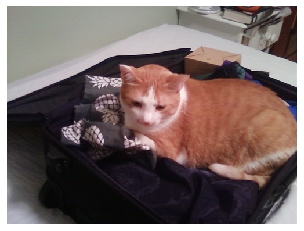

['clothes', 'luggage', 'open', 'laying', 'lying', 'white', 'view', 'bag', 'top', 'suitcase', 'orange', 'piece', 'cat']


In [21]:
show_details(idx)

http://images.cocodataset.org/val2017/000000084650.jpg


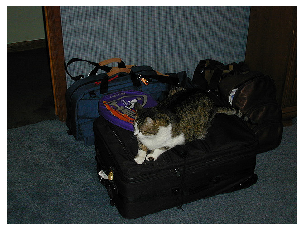

['looking', 'luggage', 'ground', 'alertly', 'laying', 'lying', 'brown', 'bag', 'suit', 'top', 'suitcase', 'case', 'sittion', 'black', 'cat']


In [22]:
show_details(closest_idx[0])

In [13]:
with open('../../static/data/urls.txt', 'w') as f:
    for url in list(df['coco_url']):
        f.write(f'{url}\n')
f.close()